In [64]:
import numpy as np #array
import pandas as pd #data set
import yfinance as yf #api table
import matplotlib.pyplot as plt #graph visualization

import torch
import torch.nn as nn #build
import torch.optim as optim #train

from sklearn.preprocessing import StandardScaler #scale
from sklearn.metrics import root_mean_squared_error #evaluate

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [66]:
ticker = 'VOO'
df = yf.download(ticker, '2023-08-01')

C:\Users\ptul0\AppData\Local\Temp\ipykernel_22748\742579654.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, '2023-08-01')
[*********************100%***********************]  1 of 1 completed


In [67]:
df #table Close High Low Open Volume

Price,Close,High,Low,Open,Volume
Ticker,VOO,VOO,VOO,VOO,VOO
Date,,,,,
2023-08-01,407.990356,408.671328,407.182881,407.873620,3118000
2023-08-02,402.338135,405.383134,401.666872,405.149632,4973700
2023-08-03,401.199860,402.941254,399.925440,400.499412,3022300
2023-08-04,399.234772,404.828611,398.894271,402.902374,5717300
2023-08-07,402.834259,402.989917,400.460553,401.092894,2598000
...,...,...,...,...,...
2025-08-06,581.640015,582.270020,577.409973,578.250000,4545000
2025-08-07,581.289978,585.520020,578.309998,584.869995,4594300


<Axes: xlabel='Date'>

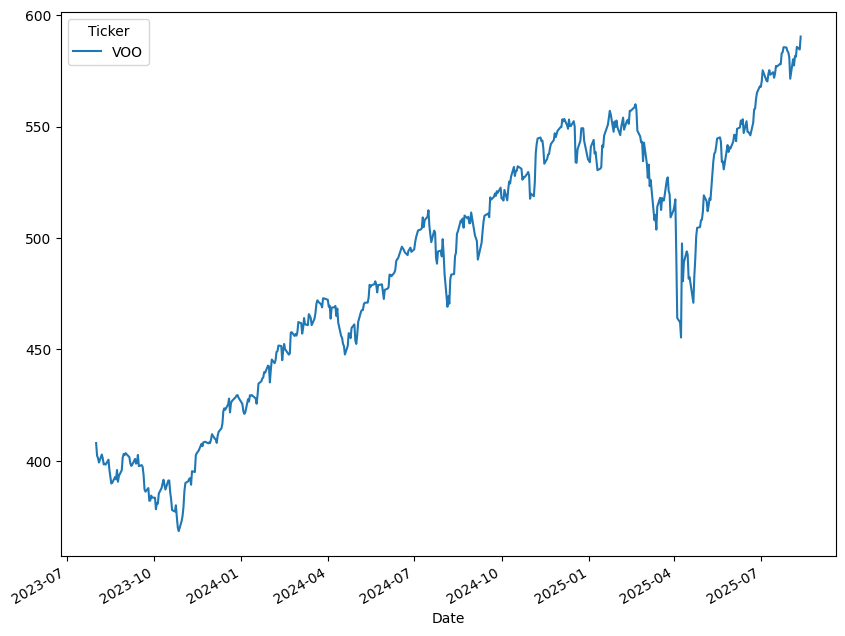

In [68]:
df.Close.plot(figsize=(10,8))

In [69]:
scaler = StandardScaler()
df['Close'] = scaler.fit_transform(df['Close'])

In [70]:
df.Close #table standard deviation of 1, mean of 0

Ticker,VOO
Date,
2023-08-01,-1.347148
2023-08-02,-1.444528
2023-08-03,-1.464140
2023-08-04,-1.497996
2023-08-07,-1.435981
...,...
2025-08-06,1.644618
2025-08-07,1.638587
2025-08-08,1.715255


In [71]:
#LSTM = Long Short-Term Memory [Recurrent Neural Network]
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length]) #sequence-based machine learning model 1+2=3 >2+3=4 >3+4=5

data = np.array(data)

In [72]:
data 

array([[[-1.34714779],
        [-1.44452848],
        [-1.46413953],
        ...,
        [-1.51458861],
        [-1.46950353],
        [-1.50654365]],

       [[-1.44452848],
        [-1.46413953],
        [-1.49799553],
        ...,
        [-1.46950353],
        [-1.50654365],
        [-1.4984987 ]],

       [[-1.46413953],
        [-1.49799553],
        [-1.43598088],
        ...,
        [-1.50654365],
        [-1.4984987 ],
        [-1.43899833]],

       ...,

       [[ 1.31337158],
        [ 1.36146359],
        [ 1.41013501],
        ...,
        [ 1.57070599],
        [ 1.64461798],
        [ 1.63858729]],

       [[ 1.36146359],
        [ 1.41013501],
        [ 1.40565537],
        ...,
        [ 1.64461798],
        [ 1.63858729],
        [ 1.71525542]],

       [[ 1.41013501],
        [ 1.40565537],
        [ 1.44907109],
        ...,
        [ 1.63858729],
        [ 1.71525542],
        [ 1.69458071]]], shape=(480, 30, 1))

In [73]:
train_size= int(0.8 * len(data))

x_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device) #last seq

x_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [74]:
x_train #clean data

tensor([[[-1.3471],
         [-1.4445],
         [-1.4641],
         ...,
         [-1.5240],
         [-1.5146],
         [-1.4695]],

        [[-1.4445],
         [-1.4641],
         [-1.4980],
         ...,
         [-1.5146],
         [-1.4695],
         [-1.5065]],

        [[-1.4641],
         [-1.4980],
         [-1.4360],
         ...,
         [-1.4695],
         [-1.5065],
         [-1.4985]],

        ...,

        [[ 1.1681],
         [ 1.0754],
         [ 1.1430],
         ...,
         [ 0.5483],
         [ 0.4542],
         [ 0.5470]],

        [[ 1.0754],
         [ 1.1430],
         [ 1.1515],
         ...,
         [ 0.4542],
         [ 0.5470],
         [ 0.5264]],

        [[ 1.1430],
         [ 1.1515],
         [ 1.1200],
         ...,
         [ 0.5470],
         [ 0.5264],
         [ 0.5287]]])

In [75]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True) #dropout=0.2
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [76]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [77]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [78]:
num_epochs = 200
for i in range(num_epochs):
    y_train_pred = model(x_train) #prediction of price

    loss = criterion(y_train_pred, y_train) #prediction error

    if i % 25 == 0:
        print(i, loss.item()) #0 0.00075371 to  25 to 175

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 0.8742241263389587
25 0.018299393355846405
50 0.010894804261624813
75 0.00828145444393158
100 0.007285619620233774
125 0.0065975431352853775
150 0.005980681627988815
175 0.0054308087565004826


In [79]:
model.eval()
y_test_pred = model(x_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy()) #invesre to price unit
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy()) 
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy()) 
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy()) 


In [80]:
train_rmse =root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])

In [81]:
train_rmse 

4.1354146003723145

In [82]:
test_rmse 

8.110548973083496

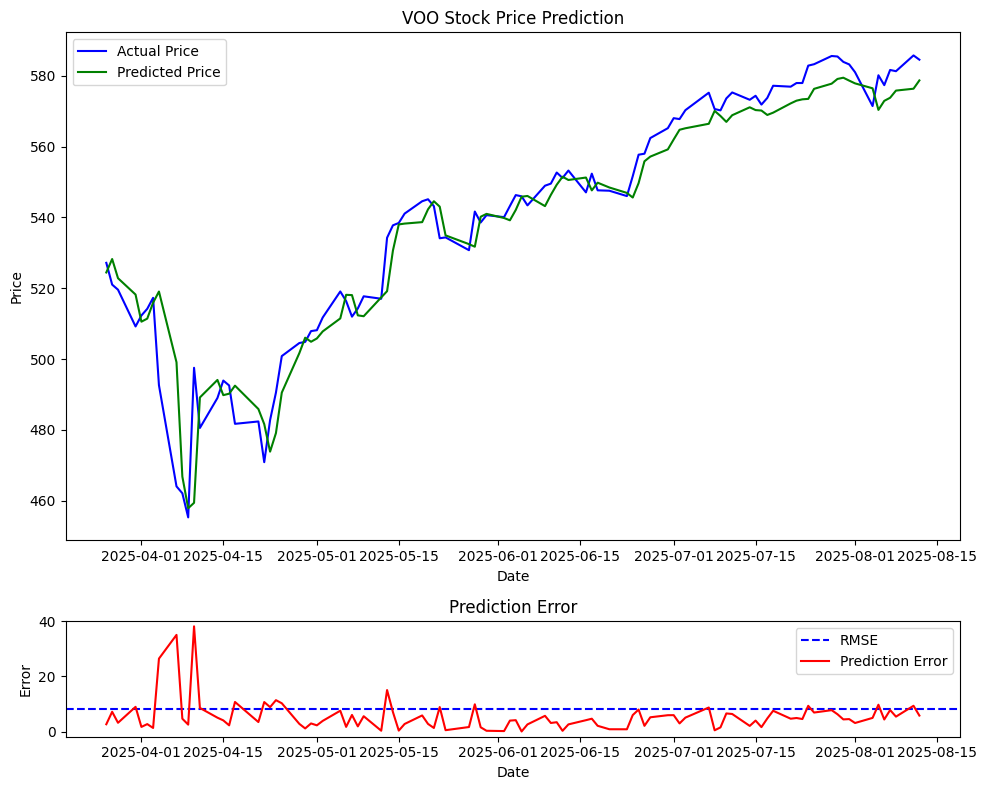

In [83]:
#visualization
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(4,1)
axl = fig.add_subplot(gs[:3, 0])

axl.plot(df.iloc[-len(y_test):].index, y_test, color = 'blue', label = 'Actual Price')
axl.plot(df.iloc[-len(y_test):].index, y_test_pred, color = 'green', label = 'Predicted Price')
axl.legend()
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3, 0])
ax2.axhline(test_rmse, color ='blue', linestyle ='--', label='RMSE')
ax2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), 'r', label='Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')

plt.tight_layout()
plt.show()

In [ ]:
#conclusion: predicted prices were slightly accurate & close to actual price but delayed in date